In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Secret data generating mechanism that as the optimisation engineer you don't have access to. 
# However, to evaluate the final solution beyond the training objective 
# (which is quite likely close to zero for any training procedure due to huge number of parameters) 
# we need access to w_star. 

# You may feel free to use the variable data_dim. All other variables here are off limits. 

# Data description: 30 data points for 100 dimensional regression problem. 

data_dim = 100
num_data = 30
sparsity = 3
np.random.seed(100) 
w_temp = np.random.randn(sparsity)
indices = np.random.choice(data_dim, sparsity, replace=False)
w_star=np.zeros(data_dim)
w_star[indices]=w_temp

data_matrix = np.random.randn(num_data, data_dim)*0.5
labels = np.dot(data_matrix, w_star) + 0.0*np.random.randn(num_data)


global_A = np.dot(data_matrix.T, data_matrix) / num_data
global_b = np.dot(data_matrix.T,labels) / num_data
global_c = 0.5* np.dot(labels, labels) / num_data
global_w_star = np.array(w_star)

print('w_star=', global_w_star)
print('Non-zero coeffs=', np.where(np.abs(global_w_star)>1e-5))
eig_vals, eig_vecs = np.linalg.eig(global_A)
smoothness_coeff = np.real(np.max(eig_vals))
print('Smoothness coeff=', smoothness_coeff)



w_star= [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.1530358   0.          0.
  0.         -1.74976547  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.3426804   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

# Eigenvalues of A

The code in the cell below checks if the eigenvalues of A are negative. This would imply that the matrix A is not PSD.

In [3]:
count = np.sum(eig_vals < 0)
print(count, "eigen values are negative")

34 eigen values are negative


In [4]:

def get_value(w):
    A = global_A
    b = global_b
    return 0.5*np.dot(w, np.dot(A,w)) - np.dot(b,w) + global_c

def get_gradient(w):
    A = global_A
    b = global_b
    return np.dot(A,w)-b

    

# Question 1:

Assume you have oracle access to a regression error function (call it f) on some training data. Solve the LASSO optimisation problem, over some given l1 norm ball using the projected gradient descent.

1. Write the function for the l1 norm projection oracle, l2 norm projection oracle and the respective PGD steps.

2. Plot f(w_t) vs t for the PGD algorithm with l2 norm projection oracle. The step size is fixed to eta=0.01. Repeat the plots with different l2 norm constraints: 0.1, 0.5, 1, 2, 5 (on the same plot). 

3. Plot f(w_t) vs t for the PGD algorithm with l1 norm projection oracle. The step size is fixed to eta=0.01. Repeat the plots with different l1 norm constraints: 0.1, 0.5, 1, 2, 5 (on the same plot).

4. Let $w^1_\lambda$ be the result of running PGD with the l1 norm constraint of lambda for 500 iterations. Similarly let $w^2_\mu$ be the result of running PGD with the l2 norm constraint of mu for 500 iterations. Give two separate cells with each cell containing 2 plots as follows: 

    4a. In the first cell: $f(w^1_\lambda)$ vs $\lambda$ and $||w^1_\lambda - w^* ||$ vs $\lambda$.    
    4b. In the Second cell: $f(w^2_\mu)$ vs $\mu$ and $||w^2_\mu - w^* ||$ vs $\mu$. 
    
    Note 1: $w^*$ is the vector used in data generation. 
    Note 2: Using $w^*$ is illegal anywhere else. But it's okay here to just make a point.
    Note 3: The range of mu and lambda to plot may be taken to be 0.1 to 3.
    Note 4: We can take the norm above to simply be the difference in the set of non-zero components

5. Summarise and explain your findings in a markdown cell

In [5]:
# Question 1 part 1

def projection_oracle_l2(w, l2_norm):
    """Projects a given vector onto a ball (as defined by l2_norm) of given radius around the origin
    
    Args:
        w (ndarray): given vector to be projected 
        l2_norm (ndarray): radius of the l2_norm ball
    
    Returns:
        w_projected (ndarray): projected vector
    """
    norm_w = np.sqrt(np.dot(w,w))
    if norm_w <= l2_norm:
        w_projected = w
       
    else:
        w_hat = w/norm_w
        w_projected = w_hat*l2_norm
    
    return w_projected

def compute_l1_norm(x):
    """Function to compute the l1 norm of a given vector
    
    Args:
        x (ndarray): vector whose l1 norm is to be computed
    
    Returns:
        l1_norm (float): l1 norm of the given vector
    """
    
    x = np.array(x)
    l1_norm = np.sum(np.abs(x))
    
    return l1_norm

def vector_plus(x):
    """Function to retain positive values of a vector and set negative values to 0
    
    Args:
        x (ndarray): input vector
    
    Returns:
        x_plus (ndarray): output vector all of whose negative elements have been
            set to zero
    """
    x = np.array(x)
    mask = x>0
    x_plus = x*mask
    
    return x_plus


def projection_oracle_l1(w, l1_norm):
    """Projects a given vector onto a ball (as defined by l1_norm) of given radius around the origin
    
    Args:
        w (ndarray): given vector to be projected 
        l1_norm (ndarray): radius of the l1_norm ball about the origin
    
    Returns:
        w_projected (ndarray): projected vector
    """
    w = np.array(w)
    w_sign = 2*(w>0) - 1
    w_pos = np.abs(w)
    w_norm = compute_l1_norm(w)
    
    if w_norm <= l1_norm:
        w_projected = w
    else:
        # tolerance value in projection
        epsilon = 10**(-5)
        # original vector is outside l1 ball
        tau_low = 0
        
        # finding a tau high that pushes given vector into l1 ball
        tau_high = 1
        one_vector = np.ones(len(w))
        forced_vector = vector_plus(w_pos - tau_high*one_vector)
        while compute_l1_norm(forced_vector) > l1_norm:
            tau_high = 2*tau_high
            forced_vector = vector_plus(w_pos - tau_high*one_vector)
            
        tau = (tau_high + tau_low)/2
        w_projected = w_sign*vector_plus(w_pos - tau*one_vector) 
        norm_w_projected= compute_l1_norm(w_projected)
        
        while np.abs(norm_w_projected - l1_norm) > epsilon:
            # "projection" too far in, gotta reduce tau
            if norm_w_projected < l1_norm:
                tau_high = tau
            # "projection" is still too close to the original point
            elif norm_w_projected > l1_norm:
                tau_low = tau
            tau = (tau_high + tau_low)/2
            w_projected = w_sign*(vector_plus(w_pos - tau*one_vector))
            norm_w_projected = compute_l1_norm(w_projected)
    
    return w_projected

def PGD_step_l2(w, l2_norm, eta=0.1):
    """Performs one step of projected gradient descent for l2 norm
    
    Args:
        w (ndarray): iterate at the t-th iteration
        l2_norm (float): radius of the l2_norm ball onto which given vector must be projected
        eta (float): step size for PGD
    
    Returns:
        w_next_projected (ndarray): iterate at the t+1-th iteration
        
    """
    
    grad_w = get_gradient(w)

    
    # update
    w_next = w - eta*grad_w
    
    # projection
    w_next_projected = projection_oracle_l2(w_next, l2_norm)
    
    return w_next_projected

def PGD_step_l1(w, l1_norm, eta=0.1):
    """Performs one step of projected gradient descent for l1 norm
    
    Args:
        w (ndarray): iterate at the t-th iteration
        l1_norm (float): radius of the l1_norm ball onto which given vector must be projected
        eta (float): step size for PGD
    
    Returns:
        w_next_projected (ndarray): iterate at the t+1-th iteration
        
    """
    
    grad_w = get_gradient(w)
    
    # update
    w_next = w - eta*grad_w
    
    # projection
    w_next_projected = projection_oracle_l1(w_next, l1_norm)
    
    return w_next_projected
    

norm constraint: 0.1 
 L2 norm of w: 0.09999999999999999 
 L1 norm of w 0.756876132752695
norm constraint: 0.5 
 L2 norm of w: 0.5 
 L1 norm of w 3.698317302864997
norm constraint: 1 
 L2 norm of w: 0.9999999999999999 
 L1 norm of w 7.268634616501321
norm constraint: 2 
 L2 norm of w: 1.0488881049986283 
 L1 norm of w 7.62774105636881
norm constraint: 5 
 L2 norm of w: 1.0488881049986283 
 L1 norm of w 7.62774105636881


<Figure size 432x288 with 0 Axes>

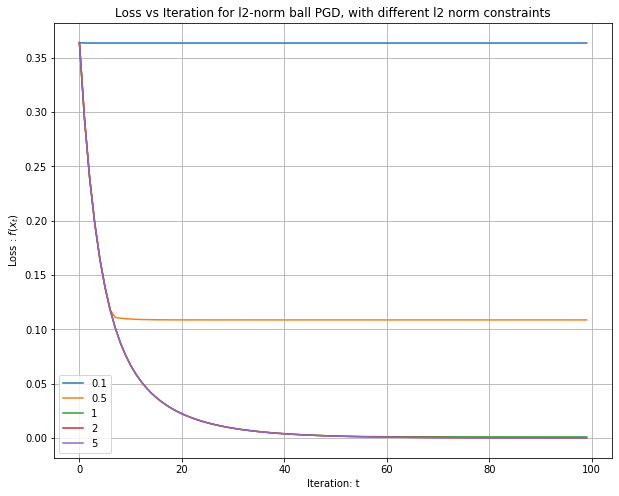

In [6]:
# Question 1 part 2
w_all = []
f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]
for norm_constraint in norm_constraint_vals:
    f_vals=[]
    w=np.zeros(data_dim)

    for t in range(100):
        w = PGD_step_l2(w, norm_constraint)
        f_vals.append(get_value(w))
        
    print("norm constraint:", norm_constraint,"\n","L2 norm of w:", 
          np.sqrt(np.dot(w,w)), "\n", "L1 norm of w", compute_l1_norm(w))
    w_all.append(w)
    
    
    f_vals_all.append(f_vals)

    
################# Comparing solutions #####################
# print("Energy of error between solutions obtained with 1,2,5 ")
# print(np.sqrt(np.dot(w_all[-1] - w_all[-2],w_all[-1] - w_all[-2] )))
# print(np.sqrt(np.dot(w_all[-1] - w_star,w_all[-1] - w_star )))
# print(np.sqrt(np.dot(w_all[-2] - w_star,w_all[-2] - w_star )))

# print(np.sqrt(np.dot(w_all[-3] - w_all[-2],w_all[-3] - w_all[-2] )))
# print(np.sqrt(np.dot(w_all[-3] - w_star,w_all[-3] - w_star )))
# print(np.sqrt(np.dot(get_gradient(w_all[-1]), get_gradient(w_all[-1]))))
###########################################################


plt.figure(figsize = (10,8))
plt.grid()
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l2-norm ball PGD, with different l2 norm constraints')
plt.show()


<Figure size 432x288 with 0 Axes>

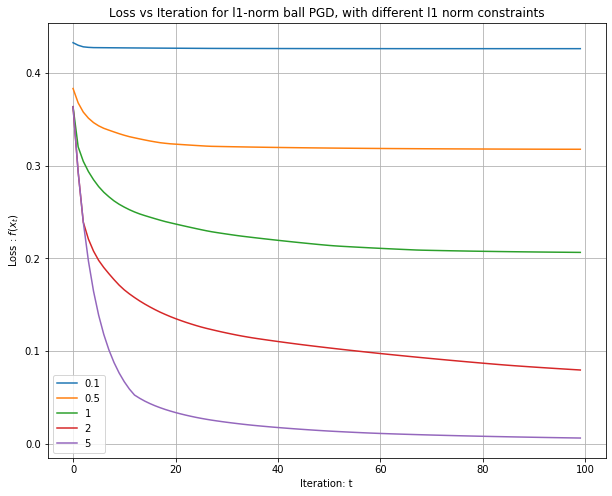

In [7]:
# Question 1 part 3

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]
for norm_constraint in norm_constraint_vals:
    f_vals=[]
    w=np.zeros(data_dim)
    for t in range(100):
        w = PGD_step_l1(w, norm_constraint)
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
    
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l1-norm ball PGD, with different l1 norm constraints')
plt.show()

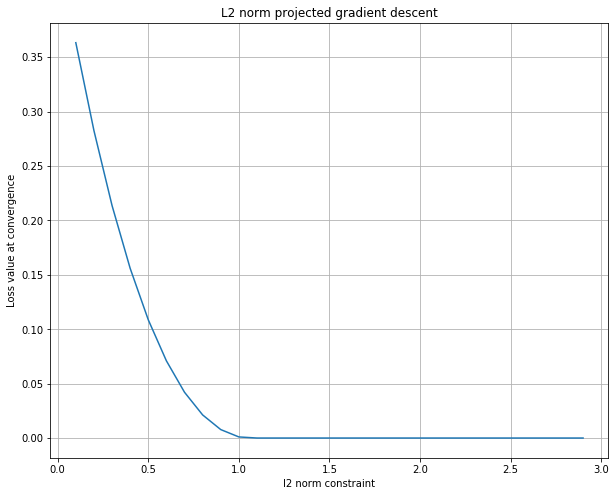

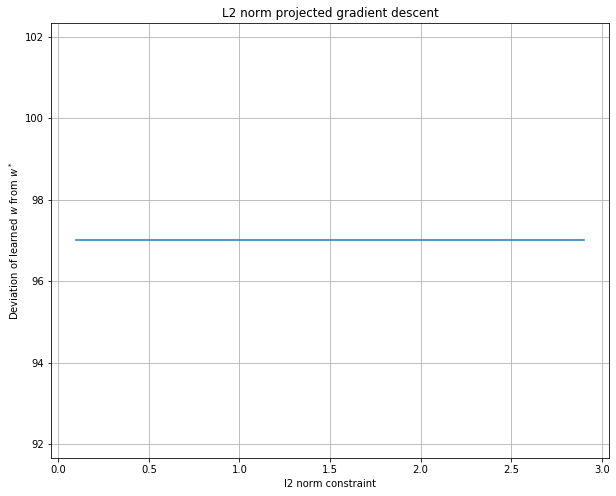

In [8]:
# Question 1 part 4a

norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = PGD_step_l2(w, norm_constraint)
    loss_values.append(get_value(w))

    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l2 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L2 norm projected gradient descent')
plt.show()

plt.figure(figsize = (10,8))
plt.grid()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l2 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L2 norm projected gradient descent')
plt.show()

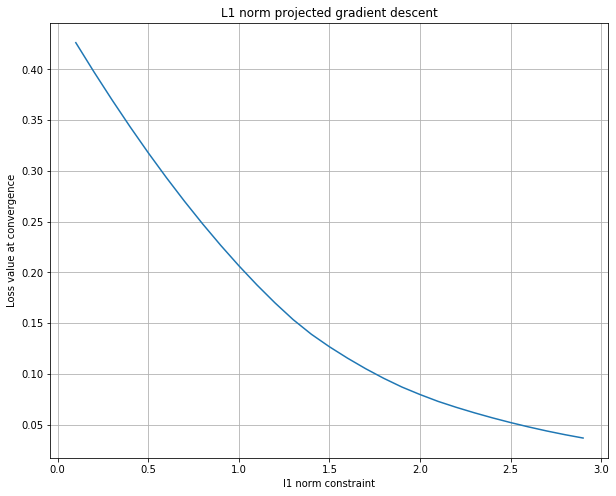

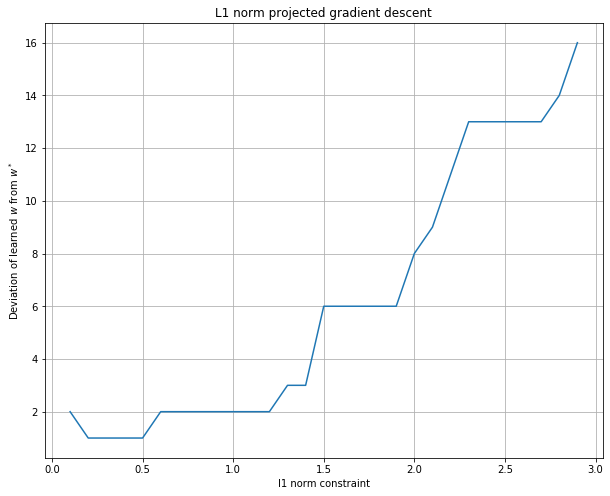

In [9]:
# Question 1 part 4b

norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = PGD_step_l1(w, norm_constraint)
    loss_values.append(get_value(w))
    
    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l1 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L1 norm projected gradient descent')
plt.show()

plt.figure(figsize = (10,8))
plt.grid()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l1 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L1 norm projected gradient descent')
plt.show()

In [10]:
print("l1_norm:", compute_l1_norm(w_star))
print("l2_norm:", (np.sqrt(np.dot(w_star, w_star))))


l1_norm: 3.2454816789458434
l2_norm: 2.1233465641558884


### Question 1 Part 5:

**Note**: An implementation detail is that the same vector w_star is produced for every run of the notebook as the numpy random seed is set to a fixed value. Therefore, all analysis is presented for the w_star with

- l1_norm(w*) = 3.24
- l2_norm(w*) = 2.12

#### Observations about L2 norm ball PGD:

- The iterate and consequently the funciton value change very little for an l2 norm ball constraint of 0.1. However for radii of 0.5, 1, 2 and 5, the function value decreases for a few iterations and remains constant later on.
- For L2 norm radius of 1,2 and 5 the solution converges to nearly the same point which is not equal to w_star. 
- In the first case, when radius = 0.1, the behaviour of PGD indicates that the chosen constraint is too small to make any progress. At every iteration, PGD is pushing $x_t$ out of the L2 norm ball which is then being projected back onto the same position leading to $x_t$ and $f(x_t)$ being nearly the same for every iteration. When the radius is 0.5, the algorithm makes some progress before the same process repeats. This can be numerically verified. Computation of the gradient after 100 iterations reveals that it is still non-zero (*code commented out in the cell*) indicating that the function can still be decreased. Further for radius = 0.1, 0.5 and 1, the solutions are all on the boundary.
- In the case of radius = 2,5 the algorithm converges to a point inside the L2 norm ball after a 100 iterations which is not equal to w*. However, the evaluation of the gradient at this point reveals that it is quite close to zero $\left( \approx 10^{-3} \right)$. This indicates that the function is converging to some local optimum and not necessarily w_star. 

Why is this possible? Consider the problem statement.

\begin{align}
num\_data &= 30 \\
D &= data\_matrix \\
l &= labels = Dw^* \\
A &= \frac{D^TD}{30} \\
B &= \frac{D^Tl}{30} = \frac{(D^TD)w^* }{30} \\
C &= \frac{l^Tl}{60} = \frac{w^{* T}(D^T D) w^* }{60} \\
f(w) &= \frac{1}{2}w^T A W - B^Tw + C \\
    &= \frac{1}{60} w^T (D^T D) w - \frac{1}{30} w^{* T} D^T D w + \frac{1}{60} w^{* T} D^T D w^*  
\end{align}

Clearly 

\begin{equation}
f(w^* ) = 0
\end{equation}

Also

\begin{align}
\nabla f(w) &= \frac{1}{30} (D^T D) w - \frac{1}{30} (D^T D) w^* \\
\nabla f(w^* ) &= 0
\end{align}

Clearly, if this were an unconstrained optimization problem, $w^*$ satisfies the FONC. Further f(w) is a quadratic in w. Therefore f(w) is convex **iff** $D^T D$ is PSD. However as shown at the start of the notebook this not true as A has negative eigenvalues. Therefore f(w) is non-convex and can have local optima. In this case there exists a stationary point with L2 norm $\approx 1.04$ which the solution converges to. This is the solution that PGD with L2 norm ball radius = 1,2,5 converges to.

#### Observations from L1 norm ball PGD:

- PGD reaches lower values of the objective function for higher values of L1 norm ball radius. This can again be attributed to the radius of the ball being too small or sufficiently large as has been done above. 
- One interesting question to answer is why PGD with L1 norm ball radii 1,2 and 5 don't converge to the same solution (local optimum other than w^* ) as has been argued above. This is because the solution with L2 norm $\approx 1.04$ has a L1 norm $> 7$ which is why it is not a feasible solution for the given problem.



#### Observations from question 4:

- Once again from the first plot of 4a it can be seen that for all values of the L2 norm constraint greater than one the algorithm converges to the same (not $w^*$) solution with f(w) = 0.
- By comparing the plots of deviation of w from w_star it is evident that the deviation is lower in the case of    L1 norm projected gradient descent rather than L2 norm gradient descent. This is because the metric used to measure deviation is **"the number of different non-zero components"**. Firstly, this metric is appropriate as the w_star vector is chosen to be very sparse. L2 norm minimisation produces "low energy" solutions that is solutions with lower values of L2 norm but not necessarily sparse solutions. This is exactly what can be observed from the second curve of Question 1 part 4a. The solution obtained by the L2 norm projected gradient descent nearly always has a deviation of 97 as almost all of the 100 elements of w have some (small but) non-zero value.
- In contrast, PGD constrained to the L1 norm ball produces sparse solutions. While the solutions produced do not necessarily equal w_star (as the L1 norm ball radius might not be large enough to include w_star), the number of unequal non-zero values is much lower as the solutions are more sparse.


# Question 2:

Assume you have oracle access to a regression error function (call it f) on some training data. Solve the LASSO optimisation problem, over some given l1 norm ball using the Frank-Wolfe method. 

1. Write the function for the l1 norm LMO, l2 norm LMO and the respective FW steps.

2. Plot f(w_t) vs t for the FW algorithm with l2 norm LMO. Repeat the plots with different l2 norm constraints: 0.1,0.5,1,2,5 (on the same plot). 

3. Plot f(w_t) vs t for the FW algorithm with l1 norm LMO. Repeat the plots with different l1 norm constraints: 0.1,0.5,1,2,5 (on the same plot). 

4. Let $w^1_\lambda$ be the result of running FW with the l1 norm constraint of lambda for 500 iterations. Similarly let $w^2_\mu$ be the result of running FW with the l2 norm constraint of mu for 500 iterations. Give two separate plots with each plot containing 2 curves as follows: 

    4a. In the first plot: $f(w^1_\lambda)$ vs $\lambda$ and $||w^1_\lambda - w^* ||$ vs $\lambda$.    
    4b. In the Second plot: $f(w^2_\mu)$ vs $\mu$ and $||w^2_\mu - w^* ||$ vs $\mu$. 
    
    Note 1: $w^*$ is the vector used in data generation. 
    Note 2: Using $w^*$ is illegal anywhere else. But it's okay here to just make a point.
    Note 3: The range of mu and lambda to plot may be taken to be 0.1 to 3.
    Note 4: We can take the norm above to simply be the difference in the set of non-zero components
    
5. Summarise and explain your findings on 2,3,4 above in a markdown cell

In [11]:
# Question 2 part 1


def LMO_l2(u, l2_norm):
    """Linear minimization oracle for l2 norm ball
    
    Function to find the vector x belonging to the l2 norm ball
    of radius l2_norm which minimizes u*x
    
    Args:
        u (ndarray): direction of minimization
        l2_norm (ndarray): radius of l2_norm ball
    
    Returns:
        x (ndarray): vector belonging to the l2_norm ball which
            minimizes u*x (dot product)
    """
    u_norm = np.sqrt(np.dot(u,u))
    x = l2_norm*(-1*u)/u_norm
    
    return x

def LMO_l1(u, l1_norm):
    """Linear minimization oracle for l1 norm ball
    
    Function to find the vector x belonging to the l1 norm ball
    of radius l1_norm which minimizes u*x. This amounts to testing 
    the vertices of the corner region of the l1 norm ball which is a 
    convex hull of hte vertex vectors.
    
    Args:
        u (ndarray): direction of minimization
        l1_norm (ndarray): radius of l1_norm ball
    
    Returns:
        x (ndarray): vector belonging to the l1_norm ball which
            minimizes u*x (dot product)
    """
    
    # vertices are simply +l1_norm*canonical_basis and -l1_norm*canonical_basis
    num_dim = len(u)
    vertices = l1_norm*np.concatenate((np.identity(num_dim), -1*np.identity(num_dim)), axis = 0)
    dot_products = np.dot(vertices, u)
    x = vertices[np.argmin(dot_products),:]
    
    return x
    
def FW_step_l2(w, l2_norm, gamma):
    """Function to perform one iteration of Frank-Wolfe for l2 norm ball constraint
    
    Args:
        w (ndarray): iterate at the t-th iteration
        l2_norm (float): radius of the l2_norm ball
        gamma (float): parameter of the FW update
        
    Returns:
        w_next (ndarray): iterate at the t+1-th iteration
        
    """
    
    grad_w = get_gradient(w)
    y_t = LMO_l2(grad_w,l2_norm)
    
    w_next = gamma*y_t + (1 - gamma)*w
    
    return w_next
    

def FW_step_l1(w, l1_norm, gamma):
    """Function to perform one iteration of Frank-Wolfe for l1 norm ball constraint
    
    Args:
        w (ndarray): iterate at the t-th iteration
        l1_norm (float): radius of the l1_norm ball
        gamma (float): parameter of the FW update
        
    Returns:
        w_next (ndarray): iterate at the t+1-th iteration
        
    """
    
    grad_w = get_gradient(w)
    y_t = LMO_l1(grad_w,l1_norm)
    
    w_next = gamma*y_t + (1 - gamma)*w
    
    return w_next
    


<Figure size 432x288 with 0 Axes>

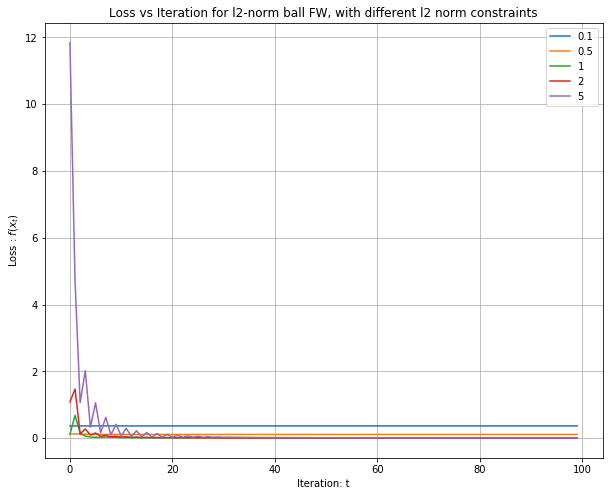

In [12]:
# Question 2 part 2

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]
for norm_constraint in norm_constraint_vals:
    f_vals=[]
    w=np.zeros(data_dim)

    for t in range(100):
        w = FW_step_l2(w, norm_constraint, gamma=2./(t+2))
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
    
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l2-norm ball FW, with different l2 norm constraints')
plt.show()



<Figure size 432x288 with 0 Axes>

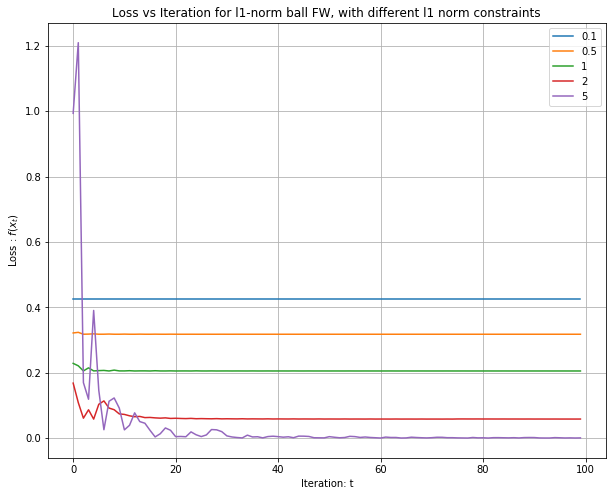

In [13]:
# Question 2 part 3

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]

# for value in list: does this not iterate through elements randomly
for norm_constraint in norm_constraint_vals:
#     print(norm_constraint)
    f_vals=[]
    w=np.zeros(data_dim)
    for t in range(100):
        w = FW_step_l1(w, norm_constraint, gamma=2./(t+2))
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
    
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l1-norm ball FW, with different l1 norm constraints')
plt.show()

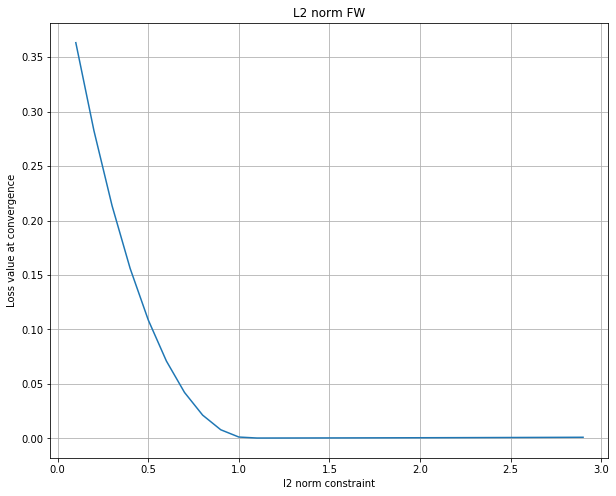

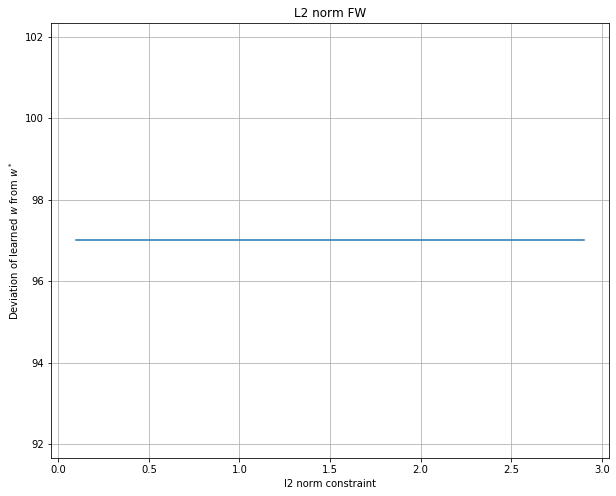

In [14]:
# Question 2 part 4a


norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = FW_step_l2(w, norm_constraint, gamma=2./(t+2))
    loss_values.append(get_value(w))

    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l2 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L2 norm FW')
plt.show()

plt.figure(figsize = (10,8))
plt.grid()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l2 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L2 norm FW')
plt.show()

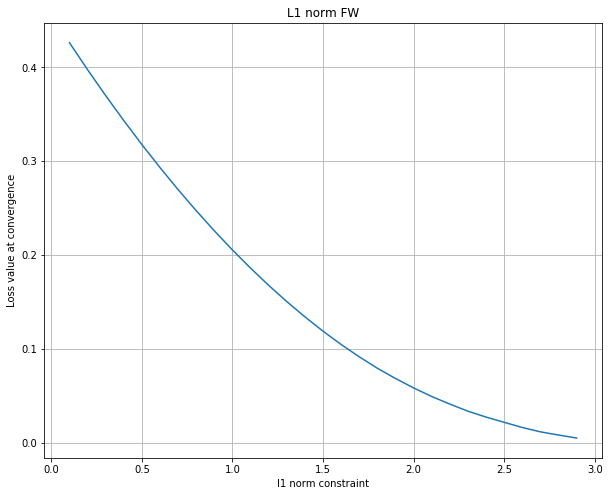

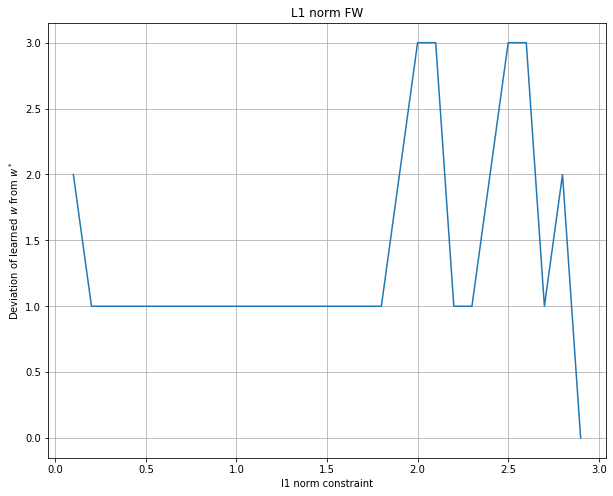

In [15]:
# Question 2 part 4b


norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = FW_step_l1(w, norm_constraint, gamma=2./(t+2))
    loss_values.append(get_value(w))
    
    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l1 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L1 norm FW')
plt.show()

plt.figure(figsize = (10,8))
plt.grid()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l1 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L1 norm FW')
plt.show()

### Question 2 part 5

- For the L2 norm ball, the LMO is implemented by finding that vector whose norm equals the radius of the ball and which is opposite to the direction of the gradient vector at $x_t$ i.e 
\begin{equation}
LMO(u,l2\_norm) = l2\_norm*\frac{-u}{||u||}
\end{equation}

- For FW (Frank-Wolfe) with L2 norm ball, loss approaches 0 for l2 norm ball radii of 1,2,5. Loss reaches a non-zero near constant value in 20 iterations for smaller radii. This is again because the radius is not large enough to include a region in which the algorithm can find an optimum value. 

- The results of part 2 reveal that there are "oscillations" in the loss value for the L2 norm constraints of 2 and 5. This shows that Frank Wolfe is not a descent algorithm i.e the function value is not guaranteed to decrease at every iteration.

- For FW with the L1 norm ball the LMO is implemented by finding a vertex of the constraint region whose inner product with the desired (gradient) vector is minimum. From the curves obtained for part 3 it is seen that loss approaches zero after 20 iterations only for L1 norm radius = 5. This indicates that of all the tested values only this region encloses a potential optimum solution which the algorithm finds. Also, once again, the decrease in the loss function values is not monotonic.

- Once again, from the second plots of question 4a and 4b it is evident that optimizing over the L1 norm ball produces sparse solutions which have a lower "deviation" (as defined) than do those produced by optimizing over the L2 norm ball. This is why the value of deviation for the L2 norm ball Frank Wolfe remains 97 throughout whereas the deviation in plot 2 of part 4b is very small.

- The first plot of 4a indicates yet again that even the Frank Wolfe algorithm finds an optimum near one after which expanding the constraint region (increasing the radius of the ball) has no effect and the same optimum is discovered. In the case of 4b, plot 1 reveals that increasing the L1 norm ball radius expands the feasible region to allow better and better solutions closer the optimum.
